## Data Visualization

# Code Explanation

This code visualizes a dataset with weight, height, and category information.

1. **Data Loading**: Loads data from `X.csv` into a DataFrame with columns for `Weight`, `Height`, and `Category`.
2. **Category Colors**: Assigns colors to categories (blue, green, red) for visual distinction.
3. **Scatter Plot**: Creates a scatter plot, showing `Weight` vs. `Height` for each category in its respective color.
   - Each category’s points are plotted with partial transparency and black edges.
4. **Labels and Grid**: Adds axis labels, a title, and a legend for clarity. A grid is enabled to improve readability.
5. **Display**: Shows the plot, highlighting differences in weight and height by category.

This provides a clear visual separation of categories based on weight and height.


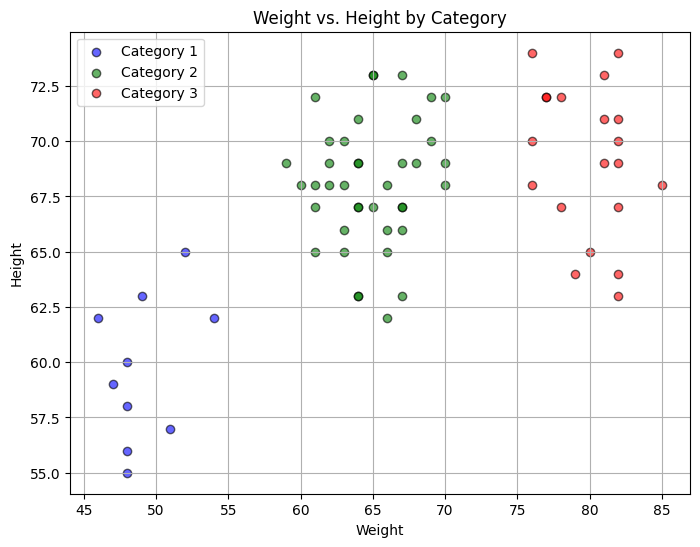

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('X.csv', header=None, names=['Weight', 'Height', 'Category'])

# Define colors for each category
colors = {1: 'blue', 2: 'green', 3: 'red'}

# Plot each category with different colors
plt.figure(figsize=(8, 6))
for category, color in colors.items():
    subset = data[data['Category'] == category]
    plt.scatter(subset['Weight'], subset['Height'], c=color, label=f'Category {category}', alpha=0.6, edgecolor='k')

# Add labels and title
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Weight vs. Height by Category')
plt.legend()
plt.grid(True)
plt.show()


## Q1

# Code Explanation

This code implements a Generalized Classification Model (GCM) to classify data based on features such as weight and height. This model insures that it has bias towards average and prefers weight more than height for classification. The following steps outline the key parts of the code:

1. **GCM Class**:
    - Initializes the model with configurable parameters: attention weights, sensitivity (c), and response bias.
    - `fit`: Normalizes the training data and stores it. Sets default values for attention weights and response bias if not provided.
    - `calculate_similarity`: Computes a weighted distance between a query point and an exemplar from the training data, using the attention weights.
    - `predict_proba`: Calculates the probability of a sample belonging to each category based on the similarity between the sample and training data.
    - `predict`: Predicts the category by selecting the class with the highest probability.

2. **Hyperparameter Tuning**:
    - Performs a grid search over different hyperparameter options (attention weights, sensitivity, and response bias).
    - Evaluates each combination using validation accuracy and selects the best parameters.

3. **Data Loading and Splitting**:
    - `load_and_split_data`: Loads the dataset from a CSV file, then splits it into training, validation, and test sets.

4. **Main Function**:
    - Loads and splits the data.
    - Runs hyperparameter tuning to find the best model configuration.
    - Trains the final model using the best parameters.
    - Evaluates the model on training, validation, and test datasets, printing the accuracy results.
    - Makes predictions on a separate test set (`y.csv`), displaying the predicted categories and corresponding probabilities.
    - Prints a classification report for the training dataset.

This setup helps optimize the model's hyperparameters and evaluates its performance on various datasets.


In [11]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import itertools

class GCM:
    def __init__(self, attention_weights=None, c=1.0, response_bias=None):
        """
        Initialize GCM model with configurable parameters
        """
        self.attention_weights = attention_weights
        self.c = c
        self.response_bias = response_bias
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Store and normalize training data"""
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)
        self.X_train = (X - self.X_mean) / self.X_std
        self.y_train = y

        if self.attention_weights is None:
            self.attention_weights = np.array([0.7, 0.3])

        if self.response_bias is None:
            self.response_bias = np.array([1.0, 1.2, 0.8])  # Reduced bias difference

    def calculate_similarity(self, x_query, x_exemplar):
        """Calculate similarity between points using weighted distance"""
        diff = x_query - x_exemplar
        weighted_diff = diff * self.attention_weights
        dist = np.sqrt(np.sum(weighted_diff ** 2))
        return np.exp(-self.c * dist)

    def predict_proba(self, X):
        """Predict probability for each category"""
        X_norm = (X - self.X_mean) / self.X_std
        n_samples = len(X)
        probabilities = np.zeros((n_samples, 3))

        for i, x_query in enumerate(X_norm):
            similarities = np.array([self.calculate_similarity(x_query, x_exemplar)
                                  for x_exemplar in self.X_train])

            for category in range(1, 4):
                category_mask = (self.y_train == category)
                category_similarities = similarities[category_mask]
                evidence = np.sum(category_similarities)
                probabilities[i, category-1] = evidence * self.response_bias[category-1]

        probabilities = probabilities / probabilities.sum(axis=1, keepdims=True)
        return probabilities

    def predict(self, X):
        """Predict categories"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1) + 1

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """
    Perform grid search for best hyperparameters while respecting assumptions
    """
    best_accuracy = 0
    best_params = None

    # Define parameter grid
    attention_weights_options = [
        [0.6, 0.4], [0.65, 0.35], [0.7, 0.3], [0.75, 0.25], [0.8, 0.2], [0.66, 0.44]  # Weight > Height
    ]
    c_options = [0.5, 1.0, 1.5, 2.0, 2.5]
    response_bias_options = [
        [1.0, 1.0, 0.7],  #  bias
        [1.0, 1.1, 0.9],  # Too mild bias towards average
        [1.0, 1.2, 0.8],  # Mild bias towards average
        [1.0, 1.3, 0.7],  # Moderate bias towards average
        [1.0, 1.4, 0.6],  # Strong bias towards average
    ]

    for weights, c, bias in itertools.product(
        attention_weights_options, c_options, response_bias_options):

        model = GCM(
            attention_weights=np.array(weights),
            c=c,
            response_bias=np.array(bias)
        )

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'attention_weights': weights,
                'c': c,
                'response_bias': bias
            }

    return best_params, best_accuracy

def load_and_split_data(filename):
    """Load data and split into train, validation, and test sets"""
    data = np.loadtxt(filename, delimiter=',')

    # Split features and labels
    X = data[:, :2]
    y = data[:, 2]

    # First split: 70 training samples into 50 train + 20 validation/test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, train_size=50, random_state=42
    )

    # Second split: 20 samples into 10 validation + 10 test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

def main():
    # Load and split data
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_data('X.csv')

    # Perform hyperparameter tuning
    best_params, val_accuracy = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    print("\nBest Parameters:")
    print(f"Attention Weights: {best_params['attention_weights']}")
    print(f"Sensitivity (c): {best_params['c']}")
    print(f"Response Bias: {best_params['response_bias']}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")

    # Train final model with best parameters
    final_model = GCM(
        attention_weights=np.array(best_params['attention_weights']),
        c=best_params['c'],
        response_bias=np.array(best_params['response_bias'])
    )

    # Fit on combined train+validation data
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])
    final_model.fit(X_train_full, y_train_full)

    # Evaluate on training data
    y_train_pred = final_model.predict(X_train_full)
    train_accuracy = accuracy_score(y_train_full, y_train_pred)
    print(f"\nTraining Accuracy: {train_accuracy:.3f}")

    # Evaluate on test data
    y_test_pred = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Load and predict on the separate test set (y.csv)
    final_test_data = np.loadtxt('y.csv', delimiter=',')
    final_predictions = final_model.predict(final_test_data)
    probabilities = final_model.predict_proba(final_test_data)

    # Print detailed results
    print("\nFinal Test Set Predictions:")
    print("Point | Weight | Height | Predicted | Probabilities (S/A/L)")
    print("-" * 65)
    for i, (pred, probs) in enumerate(zip(final_predictions, probabilities)):
        print(f"{i+1:5d} | {final_test_data[i,0]:6.1f} | {final_test_data[i,1]:6.1f} | "
              f"{pred:9d} | {probs[0]:.2f}/{probs[1]:.2f}/{probs[2]:.2f}")

    # Print detailed classification report for training data
    print("\nTraining Data Classification Report:")
    print(classification_report(y_train_full, y_train_pred))

if __name__ == "__main__":
    main()


Best Parameters:
Attention Weights: [0.6, 0.4]
Sensitivity (c): 2.0
Response Bias: [1.0, 1.1, 0.9]
Validation Accuracy: 1.000

Training Accuracy: 0.917
Test Accuracy: 0.900

Final Test Set Predictions:
Point | Weight | Height | Predicted | Probabilities (S/A/L)
-----------------------------------------------------------------
    1 |   74.0 |   67.0 |         2 | 0.01/0.64/0.34
    2 |   69.0 |   63.0 |         2 | 0.04/0.79/0.18
    3 |   92.0 |   81.0 |         3 | 0.01/0.37/0.63
    4 |   64.0 |   61.0 |         2 | 0.09/0.80/0.11
    5 |   66.0 |   84.0 |         2 | 0.02/0.75/0.23
    6 |   76.0 |   68.0 |         2 | 0.01/0.55/0.44
    7 |   61.0 |   58.0 |         2 | 0.20/0.71/0.09
    8 |   64.0 |   76.0 |         2 | 0.02/0.84/0.14
    9 |   68.0 |   66.0 |         2 | 0.02/0.83/0.15
   10 |   34.0 |   61.0 |         1 | 0.57/0.40/0.03

Training Data Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      0.71      0.83     

# Plotting

The code generates a scatter plot to visualize the training data by its actual categories and the test data by the model’s predicted categories. Here’s a breakdown of the plotting steps:

1. **Plotting Training Data**:
    - The training data from `X.csv` is read, and points are grouped by their actual category (1, 2, or 3).
    - Each category is assigned a unique color (`blue`, `green`, `red`) to distinguish between the categories visually.
    - For each category, a scatter plot is created with circles (`'o'` markers) representing the data points, labeled with “Training Category X,” where `X` is the category number.

2. **Plotting Test Data**:
    - The test data from `y.csv` is classified using the trained GCM model, and the predicted category labels are added to the `test_data` DataFrame.
    - Using the same color scheme as the training data, each category in the test data is plotted with square markers (`'s'`), labeled as “Test Predicted Category X” for visual comparison with training data.

3. **Adding Plot Elements**:
    - Labels are added to the x-axis (`Weight`) and y-axis (`Height`), with a title describing the plot.
    - A legend differentiates between training and test categories, and a grid improves readability.

The plot provides a side-by-side view of the training categories and the model's predictions for test data, making it easy to assess model performance visually.


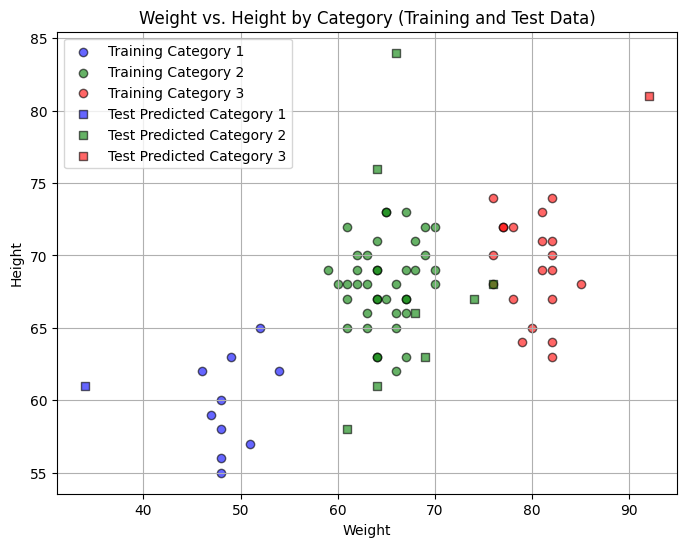

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import itertools

# Your GCM model class and related methods here...

# Loading and preparing the model
def load_and_split_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:, :2]
    y = data[:, 2]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=50, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

def main():
    # Load and split data
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_data('X.csv')

    # Hyperparameter tuning
    best_params, val_accuracy = hyperparameter_tuning(X_train, y_train, X_val, y_val)

    # Train the final model with best parameters
    final_model = GCM(
        attention_weights=np.array(best_params['attention_weights']),
        c=best_params['c'],
        response_bias=np.array(best_params['response_bias'])
    )
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])
    final_model.fit(X_train_full, y_train_full)

    # Load test data (y.csv) and predict
    test_data = pd.read_csv('y.csv', header=None, names=['Weight', 'Height'])
    test_predictions = final_model.predict(test_data.to_numpy())

    # Add predicted labels to test_data
    test_data['Predicted Category'] = test_predictions

    # Define colors for each category
    colors = {1: 'blue', 2: 'green', 3: 'red'}

    # Plot training data with actual categories
    plt.figure(figsize=(8, 6))
    for category, color in colors.items():
        subset = pd.read_csv('X.csv', header=None, names=['Weight', 'Height', 'Category'])
        subset = subset[subset['Category'] == category]
        plt.scatter(subset['Weight'], subset['Height'], c=color, label=f'Training Category {category}', alpha=0.6, edgecolor='k', marker='o')

    # Plot test data with predicted categories
    for category, color in colors.items():
        subset = test_data[test_data['Predicted Category'] == category]
        plt.scatter(subset['Weight'], subset['Height'], c=color, label=f'Test Predicted Category {category}', alpha=0.6, edgecolor='k', marker='s')

    # Add labels and title
    plt.xlabel('Weight')
    plt.ylabel('Height')
    plt.title('Weight vs. Height by Category (Training and Test Data)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Here we can see the model predicts guy with weight: 76.0   and height: 68.0 as average instead of large because it has bias towards average      

## Q2

# Anderson Rational Model of Categorization

This code implements Anderson's Rational Model of Categorization (RMC) to categorize individuals based on weight and height into three categories: Small, Average, and Large.

# Anderson Rational Model of Categorization (RMC)

The Anderson Rational Model of Categorization (RMC) is a probabilistic approach to categorize new data points into pre-defined categories based on similarity to existing data. This model relies on probabilistic computations and similarity functions to decide the most likely category for each data point.

## Key Components and Steps

### 1. Initialization
The model is initialized with the following key parameters:
- **Coupling Parameter (`coupling_param`)**: Controls the degree to which new data points influence categorization, promoting or inhibiting cluster formation.
- **Feature Weights (`feature_weights`)**: Defines the importance of each feature in calculating similarity between data points.
- **Sigma (`sigma`)**: Defines the spread of the Gaussian (or RBF) kernel used in similarity computation.

### 2. Data Normalization
Normalization is essential for feature scaling, ensuring that features with different units or scales don't disproportionately affect similarity. The method `normalize_features` scales each feature to the range [0, 1].

### 3. Similarity Computation
To quantify how similar two data points are, the model uses a **Radial Basis Function (RBF) Kernel**, which calculates the exponential decay of the distance between two normalized data points. This kernel gives higher values to closer points and lower values to points further apart, making it useful for clustering.

- **Equation**:  
 $
  \text{similarity} = \exp\left(-\frac{\text{weighted\_distance}}{2 \times \sigma^2} \right)
  $
  where `weighted_distance` is calculated by the sum of squared differences, weighted by `feature_weights`.

### 4. Category Probability Calculation
The `category_probability` method calculates the likelihood of a new sample belonging to a specific category by averaging the kernel similarities of the sample with every data point in that category. The probability is then scaled by:
  - **Category size**: To account for larger categories naturally having more influence.
  - **Coupling Parameter**: A user-defined parameter that adjusts the influence of new data points on the categorization decision.

### 5. Posterior Probability Calculation
Using Bayes' theorem, the `compute_posterior` method computes the posterior probability of each category for a given sample, assuming uniform prior probabilities across all categories. This is achieved by multiplying the prior with the calculated category probability.

- **Bayesian Update**:  
  $
  \text{posterior} = \text{prior} \times \text{likelihood}
  $

### 6. Training the Model
In the `train` method, the model processes initial training data by:
  - Calculating the **normalization statistics** (min and max for each feature) for scaling.
  - Distributing samples into corresponding categories for later similarity-based comparisons.

### 7. Making Predictions
When predicting the category of a new sample, the model calculates posterior probabilities for each category and normalizes these to sum to 1. The category with the highest posterior probability is then chosen as the predicted category.

The `predict` method outputs both the predicted category and the probabilities for each category, providing insight into the certainty of the classification.







Best parameters found: {'coupling_param': 0.3, 'sigma': 0.05, 'feature_weights': array([0.7, 0.3])}
Validation accuracy: 1.00

Predictions for test data:
Weight: 74.0 kg, Height: 67.0 inches
Predicted category: Large
Probabilities: Small: 0.000, Average: 0.280, Large: 0.720

Weight: 69.0 kg, Height: 63.0 inches
Predicted category: Average
Probabilities: Small: 0.000, Average: 1.000, Large: 0.000

Weight: 92.0 kg, Height: 81.0 inches
Predicted category: Large
Probabilities: Small: 0.000, Average: 0.000, Large: 1.000

Weight: 64.0 kg, Height: 61.0 inches
Predicted category: Average
Probabilities: Small: 0.000, Average: 1.000, Large: 0.000

Weight: 66.0 kg, Height: 84.0 inches
Predicted category: Average
Probabilities: Small: 0.000, Average: 0.999, Large: 0.001

Weight: 76.0 kg, Height: 68.0 inches
Predicted category: Large
Probabilities: Small: 0.000, Average: 0.031, Large: 0.969

Weight: 61.0 kg, Height: 58.0 inches
Predicted category: Average
Probabilities: Small: 0.038, Average: 0.962

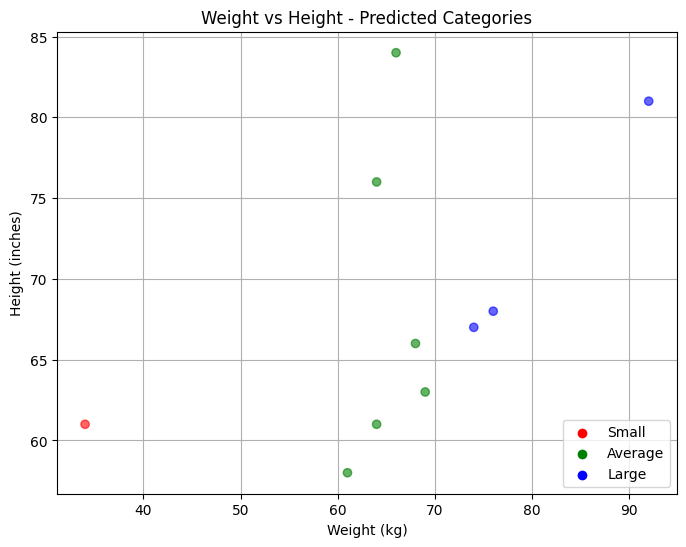

In [13]:
import pandas as pd
import numpy as np

class dLocalMAP:

    def __init__(self, coupling_param=0.5, feature_weights=None, sigma=0.1):
        """
        Initialize the model with tuned parameters
        coupling_param: controls cluster formation (0-1)
        feature_weights: importance of each feature
        sigma: controls the spread of the Gaussian kernel
        """
        self.categories = {1: [], 2: [], 3: []}  # Using numeric keys
        self.coupling = coupling_param
        self.sigma = sigma
        self.feature_weights = feature_weights if feature_weights is not None else np.array([0.7, 0.3])
        self.total_samples = 0
        self.stimuli = None  # To store external stimuli

    def normalize_features(self, features):
        """Normalize features using stored statistics"""
        return (features - self.mins) / (self.maxs - self.mins + 1e-10)

    def compute_statistics(self, data):
        """Compute and store normalization statistics"""
        self.mins = np.min(data[:, :2], axis=0)
        self.maxs = np.max(data[:, :2], axis=0)

    def kernel_similarity(self, x1, x2):
        """Compute similarity using RBF kernel"""
        weighted_dist = np.sum(self.feature_weights * (x1 - x2) ** 2)
        return np.exp(-weighted_dist / (2 * self.sigma ** 2))

    def category_probability(self, sample, category_data):
        """Compute posterior probability of a sample belonging to a category"""
        if len(category_data) == 0:
            return self.coupling / (3 * (1 + self.total_samples))

        norm_sample = self.normalize_features(sample[:2])
        norm_category = self.normalize_features(category_data[:, :2])

        # Compute similarities to all points in category
        similarities = np.array([self.kernel_similarity(norm_sample, x) for x in norm_category])

        # Weight by category size and coupling parameter
        category_prob = (np.mean(similarities) * len(category_data) * self.coupling) / (1 + self.total_samples)

        # Incorporating external stimuli as additional factor
        if self.stimuli is not None:
            stimulus_factor = self.stimuli.get(category_data[0, 2], 1)  # Example: Use first sample's category as key
            category_prob *= stimulus_factor

        return category_prob

    def compute_posterior(self, sample, category_data):
        """Compute posterior probability for a category using Bayes' theorem"""
        prior = 1 / 3  # Assuming uniform prior for simplicity (can be modified)
        likelihood = self.category_probability(sample, category_data)

        # Posterior = Prior * Likelihood (simplified; could incorporate more factors)
        posterior = prior * likelihood
        return posterior

    def train(self, data, stimuli=None):
        """Train the model on data"""
        self.compute_statistics(data)
        self.stimuli = stimuli  # Store stimuli if provided

        for sample in data:
            category = int(sample[2])  # Convert to int to be safe
            self.categories[category].append(sample)
            self.total_samples += 1

        # Convert lists to numpy arrays for efficiency
        for category in self.categories:
            if self.categories[category]:
                self.categories[category] = np.array(self.categories[category])

    def predict(self, sample):
        """Predict category with probabilities using posterior"""
        probabilities = {}

        # Compute posterior probabilities for each category
        for category in self.categories:
            if isinstance(self.categories[category], list):
                category_data = np.array(self.categories[category]) if self.categories[category] else np.array([])
            else:
                category_data = self.categories[category]

            posterior = self.compute_posterior(sample, category_data)
            probabilities[category] = posterior

        # Normalize probabilities
        total_prob = sum(probabilities.values())
        if total_prob > 0:
            probabilities = {k: v / total_prob for k, v in probabilities.items()}
        else:
            # Fallback to uniform distribution if all probabilities are zero
            probabilities = {k: 1 / 3 for k in self.categories}

        # Return predicted category and probabilities
        predicted_category = max(probabilities.items(), key=lambda x: x[1])[0]
        return predicted_category, probabilities

def evaluate_model(train_data, test_data, params, stimuli=None):
    """Evaluate model with given parameters"""
    model = dLocalMAP(**params)
    model.train(train_data, stimuli)

    predictions = []
    for sample in test_data:
        category, probs = model.predict(sample)
        predictions.append((category, probs))
    return predictions

def plot_height_weight(data, model):
    """Plots weight vs. height with points colored based on predicted categories."""
    weights = data[:, 0]  # Assuming weight is in the first column
    heights = data[:, 1]  # Assuming height is in the second column

    # Predict categories for each sample in y.csv
    predicted_categories = []
    for sample in data:
        category, _ = model.predict(sample)
        predicted_categories.append(category)

    # Convert predicted categories into colors
    color_map = {1: 'red', 2: 'green', 3: 'blue'}  # red = Small, green = Average, blue = Large
    colors = [color_map[category] for category in predicted_categories]

    # Create the plot (weight vs height, with height on y-axis)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(weights, heights, c=colors, alpha=0.6)

    # Add labels and title
    plt.xlabel('Weight (kg)')
    plt.ylabel('Height (inches)')
    plt.title('Weight vs Height - Predicted Categories')

    # Create a custom legend with categories, matching colors to category names
    plt.scatter([], [], color='red', label='Small')   # Empty scatter for legend entry
    plt.scatter([], [], color='green', label='Average')  # Empty scatter for legend entry
    plt.scatter([], [], color='blue', label='Large')    # Empty scatter for legend entry

    plt.legend(loc='lower right')  # Move legend to the bottom-right corner
    plt.grid(True)
    plt.show()

def main():
    # Load data
    train_data = pd.read_csv('X.csv', header=None).values
    test_data = pd.read_csv('y.csv', header=None).values

    # Define stimuli (external factors affecting categories)
    stimuli = {
        1: 1.0,  #1.2# Category 1 has a stimulus factor of 1.2
        2: 1.0, #1.0 # Category 2 has a stimulus factor of 1.0
        3: 1.0 #0.8   # Category 3 has a stimulus factor of 0.8
    }

    # Parameter grid for tuning
    param_grid = {
        'coupling_param': [0.3, 0.5, 0.7],
        'sigma': [0.05, 0.1, 0.2],
        'feature_weights': [np.array([0.7, 0.3]), np.array([0.8, 0.2])]
    }

    # Find best parameters using validation set
    validation_data = train_data[60:70]  # Use last 10 samples for validation
    train_subset = train_data[:60]       # Use first 60 for training

    best_params = None
    best_accuracy = 0

    for coupling in param_grid['coupling_param']:
        for sigma in param_grid['sigma']:
            for weights in param_grid['feature_weights']:
                params = {
                    'coupling_param': coupling,
                    'sigma': sigma,
                    'feature_weights': weights
                }

                model = dLocalMAP(**params)
                model.train(train_subset, stimuli)

                # Evaluate on validation set
                correct = 0
                for sample in validation_data:
                    pred, _ = model.predict(sample)
                    if pred == sample[2]:
                        correct += 1

                accuracy = correct / len(validation_data)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = params

    # Train final model with best parameters
    print(f"Best parameters found: {best_params}")
    print(f"Validation accuracy: {best_accuracy:.2f}")

    final_model = dLocalMAP(**best_params)
    final_model.train(train_data, stimuli)

    # Make predictions on test data
    print("\nPredictions for test data:")
    for sample in test_data:
        category, probs = final_model.predict(sample)
        size_label = {1: 'Small', 2: 'Average', 3: 'Large'}[category]
        print(f"Weight: {sample[0]:.1f} kg, Height: {sample[1]:.1f} inches")
        print(f"Predicted category: {size_label}")
        print(f"Probabilities: Small: {probs[1]:.3f}, Average: {probs[2]:.3f}, Large: {probs[3]:.3f}\n")

    plot_height_weight(test_data, final_model)



if __name__ == "__main__":
    main()


## Q3

Empirically validating that the above models assume the exchangeability of data.

To empirically validate that the above models assume the exchangeability of data, we feed shuffled datasets into these models.

If the models are truly exchangeable, we should obtain the same predictions regardless of the order in which the data is presented.

## Verifying the GCM model

In [14]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import itertools

class GCM:
    def __init__(self, attention_weights=None, c=1.0, response_bias=None):
        """
        Initialize GCM model with configurable parameters
        """
        self.attention_weights = attention_weights
        self.c = c
        self.response_bias = response_bias
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Store and normalize training data"""
        self.X_mean = np.mean(X, axis=0)
        self.X_std = np.std(X, axis=0)
        self.X_train = (X - self.X_mean) / self.X_std
        self.y_train = y

        if self.attention_weights is None:
            self.attention_weights = np.array([0.7, 0.3])

        if self.response_bias is None:
            self.response_bias = np.array([1.0, 1.2, 0.8])  # Reduced bias difference

    def calculate_similarity(self, x_query, x_exemplar):
        """Calculate similarity between points using weighted distance"""
        diff = x_query - x_exemplar
        weighted_diff = diff * self.attention_weights
        dist = np.sqrt(np.sum(weighted_diff ** 2))
        return np.exp(-self.c * dist)

    def predict_proba(self, X):
        """Predict probability for each category"""
        X_norm = (X - self.X_mean) / self.X_std
        n_samples = len(X)
        probabilities = np.zeros((n_samples, 3))

        for i, x_query in enumerate(X_norm):
            similarities = np.array([self.calculate_similarity(x_query, x_exemplar)
                                  for x_exemplar in self.X_train])

            for category in range(1, 4):
                category_mask = (self.y_train == category)
                category_similarities = similarities[category_mask]
                evidence = np.sum(category_similarities)
                probabilities[i, category-1] = evidence * self.response_bias[category-1]

        probabilities = probabilities / probabilities.sum(axis=1, keepdims=True)
        return probabilities

    def predict(self, X):
        """Predict categories"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1) + 1

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """
    Perform grid search for best hyperparameters while respecting assumptions
    """
    best_accuracy = 0
    best_params = None

    # Define parameter grid
    attention_weights_options = [
        [0.6, 0.4], [0.65, 0.35], [0.7, 0.3], [0.75, 0.25], [0.8, 0.2], [0.66, 0.44]  # Weight > Height
    ]
    c_options = [0.5, 1.0, 1.5, 2.0, 2.5]
    response_bias_options = [
        [1.0, 1.0, 0.7],  #  bias
        [1.0, 1.1, 0.9],  # Too mild bias towards average
        [1.0, 1.2, 0.8],  # Mild bias towards average
        [1.0, 1.3, 0.7],  # Moderate bias towards average
        [1.0, 1.4, 0.6],  # Strong bias towards average
    ]

    for weights, c, bias in itertools.product(
        attention_weights_options, c_options, response_bias_options):

        model = GCM(
            attention_weights=np.array(weights),
            c=c,
            response_bias=np.array(bias)
        )

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'attention_weights': weights,
                'c': c,
                'response_bias': bias
            }

    return best_params, best_accuracy

def load_and_split_data(filename):
    """Load data and split into train, validation, and test sets"""
    data = np.loadtxt(filename, delimiter=',')

    # Split features and labels
    X = data[:, :2]
    y = data[:, 2]

    # First split: 70 training samples into 50 train + 20 validation/test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, train_size=50, random_state=42
    )

    # Second split: 20 samples into 10 validation + 10 test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, y_train, X_val, y_val, X_test, y_test


def main():
    # Load and split data
    X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_data('X.csv')

    # Perform hyperparameter tuning
    best_params, val_accuracy = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    print("\nBest Parameters:")
    print(f"Attention Weights: {best_params['attention_weights']}")
    print(f"Sensitivity (c): {best_params['c']}")
    print(f"Response Bias: {best_params['response_bias']}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")

    # Train final model with best parameters
    final_model = GCM(
        attention_weights=np.array(best_params['attention_weights']),
        c=best_params['c'],
        response_bias=np.array(best_params['response_bias'])
    )

    # Print original training data
    print("\nOriginal Training Data:")
    for i in range(len(X_train)):
        print(f"Index {i+1}: Weight = {X_train[i][0]:.1f}, Height = {X_train[i][1]:.1f}, Label = {y_train[i]}")

    # Shuffle training data
    shuffle_indices = np.random.permutation(len(X_train))  # Generate random indices
    X_train_shuffled = X_train[shuffle_indices]
    y_train_shuffled = y_train[shuffle_indices]

    # Print shuffled training data
    print("\nShuffled Training Data:")
    for i in range(len(X_train_shuffled)):
        print(f"Index {i+1}: Weight = {X_train_shuffled[i][0]:.1f}, Height = {X_train_shuffled[i][1]:.1f}, Label = {y_train_shuffled[i]}")


    # Fit on shuffled training data
    X_train_full = np.vstack([X_train_shuffled, X_val])
    y_train_full = np.concatenate([y_train_shuffled, y_val])
    final_model.fit(X_train_full, y_train_full)

    # Evaluate on training data
    y_train_pred = final_model.predict(X_train_full)
    train_accuracy = accuracy_score(y_train_full, y_train_pred)
    print(f"\nTraining Accuracy: {train_accuracy:.3f}")

    # Evaluate on test data
    y_test_pred = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Load and predict on the separate test set (y.csv)
    final_test_data = np.loadtxt('y.csv', delimiter=',')
    final_predictions = final_model.predict(final_test_data)
    probabilities = final_model.predict_proba(final_test_data)

    # Print detailed results
    print("\nFinal Test Set Predictions:")
    print("Point | Weight | Height | Predicted | Probabilities (S/A/L)")
    print("-" * 65)
    for i, (pred, probs) in enumerate(zip(final_predictions, probabilities)):
        print(f"{i+1:5d} | {final_test_data[i,0]:6.1f} | {final_test_data[i,1]:6.1f} | "
              f"{pred:9d} | {probs[0]:.2f}/{probs[1]:.2f}/{probs[2]:.2f}")

    # Print detailed classification report for training data
    print("\nTraining Data Classification Report:")
    print(classification_report(y_train_full, y_train_pred))

if __name__ == "__main__":
    main()


Best Parameters:
Attention Weights: [0.6, 0.4]
Sensitivity (c): 2.0
Response Bias: [1.0, 1.1, 0.9]
Validation Accuracy: 1.000

Original Training Data:
Index 1: Weight = 64.0, Height = 69.0, Label = 2.0
Index 2: Weight = 62.0, Height = 68.0, Label = 2.0
Index 3: Weight = 61.0, Height = 68.0, Label = 2.0
Index 4: Weight = 67.0, Height = 69.0, Label = 2.0
Index 5: Weight = 51.0, Height = 57.0, Label = 1.0
Index 6: Weight = 82.0, Height = 69.0, Label = 3.0
Index 7: Weight = 63.0, Height = 65.0, Label = 2.0
Index 8: Weight = 59.0, Height = 69.0, Label = 2.0
Index 9: Weight = 66.0, Height = 68.0, Label = 2.0
Index 10: Weight = 64.0, Height = 63.0, Label = 2.0
Index 11: Weight = 82.0, Height = 70.0, Label = 3.0
Index 12: Weight = 61.0, Height = 67.0, Label = 2.0
Index 13: Weight = 68.0, Height = 71.0, Label = 2.0
Index 14: Weight = 68.0, Height = 69.0, Label = 2.0
Index 15: Weight = 70.0, Height = 69.0, Label = 2.0
Index 16: Weight = 81.0, Height = 71.0, Label = 3.0
Index 17: Weight = 46.0, 

## Verifying the RMC model

In [15]:
import pandas as pd
import numpy as np

class dLocalMAP:
    def __init__(self, coupling_param=0.5, feature_weights=None, sigma=0.1):
        """
        Initialize the model with tuned parameters
        coupling_param: controls cluster formation (0-1)
        feature_weights: importance of each feature
        sigma: controls the spread of the Gaussian kernel
        """
        self.categories = {1: [], 2: [], 3: []}  # Using numeric keys
        self.coupling = coupling_param
        self.sigma = sigma
        self.feature_weights = feature_weights if feature_weights is not None else np.array([0.7, 0.3])
        self.total_samples = 0
        self.stimuli = None  # To store external stimuli

    def normalize_features(self, features):
        """Normalize features using stored statistics"""
        return (features - self.mins) / (self.maxs - self.mins + 1e-10)

    def compute_statistics(self, data):
        """Compute and store normalization statistics"""
        self.mins = np.min(data[:, :2], axis=0)
        self.maxs = np.max(data[:, :2], axis=0)

    def kernel_similarity(self, x1, x2):
        """Compute similarity using RBF kernel"""
        weighted_dist = np.sum(self.feature_weights * (x1 - x2) ** 2)
        return np.exp(-weighted_dist / (2 * self.sigma ** 2))

    def category_probability(self, sample, category_data):
        """Compute posterior probability of a sample belonging to a category"""
        if len(category_data) == 0:
            return self.coupling / (3 * (1 + self.total_samples))

        norm_sample = self.normalize_features(sample[:2])
        norm_category = self.normalize_features(category_data[:, :2])

        # Compute similarities to all points in category
        similarities = np.array([self.kernel_similarity(norm_sample, x) for x in norm_category])

        # Weight by category size and coupling parameter
        category_prob = (np.mean(similarities) * len(category_data) * self.coupling) / (1 + self.total_samples)

        # Incorporating external stimuli as additional factor
        if self.stimuli is not None:
            stimulus_factor = self.stimuli.get(category_data[0, 2], 1)  # Example: Use first sample's category as key
            category_prob *= stimulus_factor

        return category_prob

    def compute_posterior(self, sample, category_data):
        """Compute posterior probability for a category using Bayes' theorem"""
        prior = 1 / 3  # Assuming uniform prior for simplicity (can be modified)
        likelihood = self.category_probability(sample, category_data)

        # Posterior = Prior * Likelihood (simplified; could incorporate more factors)
        posterior = prior * likelihood
        return posterior

    def train(self, data, stimuli=None):
        """Train the model on data"""
        self.compute_statistics(data)
        self.stimuli = stimuli  # Store stimuli if provided

        for sample in data:
            category = int(sample[2])  # Convert to int to be safe
            self.categories[category].append(sample)
            self.total_samples += 1

        # Convert lists to numpy arrays for efficiency
        for category in self.categories:
            if self.categories[category]:
                self.categories[category] = np.array(self.categories[category])

    def predict(self, sample):
        """Predict category with probabilities using posterior"""
        probabilities = {}

        # Compute posterior probabilities for each category
        for category in self.categories:
            if isinstance(self.categories[category], list):
                category_data = np.array(self.categories[category]) if self.categories[category] else np.array([])
            else:
                category_data = self.categories[category]

            posterior = self.compute_posterior(sample, category_data)
            probabilities[category] = posterior

        # Normalize probabilities
        total_prob = sum(probabilities.values())
        if total_prob > 0:
            probabilities = {k: v / total_prob for k, v in probabilities.items()}
        else:
            # Fallback to uniform distribution if all probabilities are zero
            probabilities = {k: 1 / 3 for k in self.categories}

        # Return predicted category and probabilities
        predicted_category = max(probabilities.items(), key=lambda x: x[1])[0]
        return predicted_category, probabilities

def evaluate_model(train_data, test_data, params, stimuli=None):
    """Evaluate model with given parameters"""
    model = dLocalMAP(**params)
    model.train(train_data, stimuli)

    predictions = []
    for sample in test_data:
        category, probs = model.predict(sample)
        predictions.append((category, probs))
    return predictions

def main():
    # Load data
    train_data = pd.read_csv('X.csv', header=None).values
    test_data = pd.read_csv('y.csv', header=None).values

    # Define stimuli (external factors affecting categories)
    stimuli = {
        1: 1.0,  #1.2# Category 1 has a stimulus factor of 1.2
        2: 1.0, #1.0 # Category 2 has a stimulus factor of 1.0
        3: 1.0 #0.8   # Category 3 has a stimulus factor of 0.8
    }

    # Print the original training data
    print("Original training data:")
    print(train_data)

    # Shuffle the training data
    np.random.shuffle(train_data)

    # Print the shuffled training data
    print("\nShuffled training data:")
    print(train_data)

    # Parameter grid for tuning
    param_grid = {
        'coupling_param': [0.3, 0.5, 0.7],
        'sigma': [0.05, 0.1, 0.2],
        'feature_weights': [np.array([0.7, 0.3]), np.array([0.8, 0.2])]
    }

    # Find best parameters using validation set
    validation_data = train_data[60:70]  # Use last 10 samples for validation
    train_subset = train_data[:60]       # Use first 60 for training

    best_params = None
    best_accuracy = 0

    for coupling in param_grid['coupling_param']:
        for sigma in param_grid['sigma']:
            for weights in param_grid['feature_weights']:
                params = {
                    'coupling_param': coupling,
                    'sigma': sigma,
                    'feature_weights': weights
                }

                model = dLocalMAP(**params)
                model.train(train_subset, stimuli)

                # Evaluate on validation set
                correct = 0
                for sample in validation_data:
                    pred, _ = model.predict(sample)
                    if pred == sample[2]:
                        correct += 1

                accuracy = correct / len(validation_data)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = params

    # Train final model with best parameters on shuffled training data
    print(f"Best parameters found: {best_params}")
    print(f"Validation accuracy: {best_accuracy:.2f}")

    final_model = dLocalMAP(**best_params)
    final_model.train(train_data, stimuli)

    # Make predictions on test data
    print("\nPredictions for test data:")
    for sample in test_data:
        category, probs = final_model.predict(sample)
        size_label = {1: 'Small', 2: 'Average', 3: 'Large'}[category]
        print(f"Weight: {sample[0]:.1f} kg, Height: {sample[1]:.1f} inches")
        print(f"Predicted category: {size_label}")
        print(f"Probabilities: Small: {probs[1]:.3f}, Average: {probs[2]:.3f}, Large: {probs[3]:.3f}\n")

if __name__ == "__main__":
    main()


Original training data:
[[48 58  1]
 [54 62  1]
 [48 56  1]
 [46 62  1]
 [47 59  1]
 [48 60  1]
 [48 55  1]
 [51 57  1]
 [49 63  1]
 [52 65  1]
 [64 67  2]
 [67 63  2]
 [70 68  2]
 [70 69  2]
 [60 68  2]
 [62 69  2]
 [64 69  2]
 [69 72  2]
 [61 65  2]
 [64 63  2]
 [69 70  2]
 [65 67  2]
 [66 65  2]
 [64 71  2]
 [67 67  2]
 [68 71  2]
 [64 69  2]
 [70 72  2]
 [67 69  2]
 [63 70  2]
 [67 66  2]
 [63 66  2]
 [65 73  2]
 [67 67  2]
 [62 68  2]
 [64 63  2]
 [62 70  2]
 [63 68  2]
 [68 69  2]
 [61 67  2]
 [63 65  2]
 [65 73  2]
 [61 68  2]
 [66 62  2]
 [59 69  2]
 [66 66  2]
 [66 68  2]
 [61 72  2]
 [64 67  2]
 [67 73  2]
 [81 71  3]
 [77 72  3]
 [85 68  3]
 [82 69  3]
 [82 71  3]
 [76 74  3]
 [82 70  3]
 [82 64  3]
 [77 72  3]
 [82 67  3]
 [81 73  3]
 [81 69  3]
 [82 74  3]
 [78 72  3]
 [76 70  3]
 [78 67  3]
 [76 68  3]
 [79 64  3]
 [82 63  3]
 [80 65  3]]

Shuffled training data:
[[82 63  3]
 [48 55  1]
 [66 68  2]
 [70 68  2]
 [80 65  3]
 [49 63  1]
 [63 68  2]
 [67 66  2]
 [48 60  1]
 [

---
After reshuffling the training dataset and running the models, we observed that the predicted category labels remained consistent across all runs. This confirms that the categorization results are independent of the data order, indicating that both the GCM and RMC models assume data exchangeability.